# Feature Extraction Part 2 - include Prosody features

[x] stitching different features together

In [1]:
import librosa
import librosa.display
from librosa.core import load
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_stats_from_feature(feature_input):
    feature_mean,feature_median = np.mean(feature_input.T, axis=0),np.median(feature_input.T, axis=0)
    feature_std  = np.std(feature_input.T, axis=0)
    feature_p10, feature_p90  = np.percentile(feature_input.T, 10, axis=0), np.percentile(feature_input.T, 90, axis=0)
    return np.concatenate((feature_mean,feature_median,feature_std, feature_p10, feature_p90), axis=0)

### Load Data

In [3]:
VERSION = 4
master_data = pd.read_csv(f'./dataset_info_combined_V{VERSION}.csv')
master_data = master_data[['file_path','renamed_file_path','split','sentiment_value','emotional_category']].reset_index(drop=True)
master_data_train = master_data[master_data['split']=='train']
master_data_test  = master_data[master_data['split']=='test']

feat_data_intensity = pd.read_csv('./features/intensity_attributes_11.csv')
feat_data_pitch = pd.read_csv('./features/pitch_attributes_14.csv')
feat_data_gnr = pd.read_csv('./features/glottal_to_noise_ratio_attributes_7.csv')
feat_data_hnr = pd.read_csv('./features/harmonics_to_noise_ratio_attributes_8.csv')
feat_data_local = pd.read_csv('./features/local_jitter&local_shimmer_4.csv')
feat_data_spectrum = pd.read_csv('./features/spectrum_formant_attributes_25.csv')
feat_data_list = [feat_data_intensity,feat_data_pitch,feat_data_gnr,feat_data_hnr,feat_data_local,feat_data_spectrum]

## Train dataset processing

In [ ]:
# validate MFCC 40 is first 40 slice from MFCC 60 
### Mel-Frequency Cepstral Coefficients (MFCC)
# filename = './dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav'
# sample_rate_set = 16000
# X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=sample_rate_set,offset=0.5)
# mfccs = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=60)
# feature_mfcc = np.median(mfccs.T, axis=0)
# mfccs_40 = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=40)
# feature_mfcc_40 = np.median(mfccs_40.T, axis=0)
# feature_mfcc_40 - feature_mfcc[:40]

In [4]:
filename_list_train = master_data_train.renamed_file_path.tolist()
features_train =  pd.DataFrame(columns=['feature'])
bookmark=0
sample_rate_set = 16000
start = time.time()
for index,filename in enumerate(filename_list_train):
    X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=sample_rate_set,offset=0.5)
    mfccs_60 = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=60)
    feature_mfccs_60_stats = get_stats_from_feature(mfccs_60)
    stft = np.abs(librosa.stft(X))
    feature_chroma_stft_stats = get_stats_from_feature(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    feature_mel_32_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=32, fmax=8000))
    feature_mel_64_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=64, fmax=8000))
    feature_mel_128_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=128, fmax=8000))

    feature_zcr_stats = get_stats_from_feature(librosa.feature.zero_crossing_rate(y=X))
    feature_rms_stats = get_stats_from_feature(librosa.feature.rms(y=X))
    
    features  = np.concatenate((feature_mfccs_60_stats,
                                feature_chroma_stft_stats,
                                feature_mel_32_stats,
                                feature_mel_64_stats,
                                feature_mel_128_stats,
                                feature_zcr_stats,
                                feature_rms_stats
                              ), axis=0)
    features_train.loc[bookmark] = [features]
    bookmark=bookmark+1
end = time.time()
print(f"processing duration on feature extraction part 1 train set: {round(end-start)} seconds")

/Users/bianca/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


processing duration on feature extraction part 1 train set: 292 seconds


In [5]:
prefixes = {'mfcc': 60,'chroma': 12, 'mel32': 32, 'mel64': 64,'mel128': 128, 'zcr': 1, 'rms': 1}
column_names = []
for prefix, num_features in prefixes.items():
    for prefix_stats in ['mean','median','std','p10','p90']:
        if num_features  > 1: 
            column_names.extend([f'{prefix}_{prefix_stats}_{i}' for i in range(1, num_features + 1)])
        else:
            column_names.extend([f'{prefix}_{prefix_stats}'])
assert len(column_names) == 5*(60+12+32+64+128+2) 
# print(len(column_names), 5*(60+12+32+64+128+2)) 

In [6]:
# join feature with labels
df_feat_train = pd.DataFrame(features_train['feature'].values.tolist())
df_feat_train.columns = column_names
df_joint_train = pd.concat([master_data_train.reset_index(drop=True), df_feat_train], axis=1)
df_joint_train.to_csv(f'./features/cache_features_part_1_train_V{VERSION}.csv',index=False)
print("shape with part 1 features: ", df_joint_train.shape)
for feat_data_df in feat_data_list:
    feat_data_df = feat_data_df.drop(['Emotion'], axis=1).rename(columns={'Filepath':'file_path'})
    feat_data_df.file_path = feat_data_df.file_path.str.replace('_Angry.wav', '_angry.wav')
    df_joint_train = pd.merge(df_joint_train, feat_data_df, on='file_path', how='inner')

print("shape after merged features: ", df_joint_train.shape)

files_before_drop = df_joint_train.file_path.tolist()
df_joint_train = df_joint_train.dropna(how='any').drop(columns=['GNE_min_gne','split'])
removed_filepaths = list(set(files_before_drop) - set(df_joint_train.file_path.tolist()))
print("removed filepaths if any: ", removed_filepaths) 

print("shape after drop Nan rows and constant feature: ", df_joint_train.shape)

shape with part 1 features:  (10982, 1495)
shape after merged features:  (10982, 1552)
removed filepaths if any:  ['./dataset/CREMA-D/1076_MTI_SAD_XX.wav']
shape after drop Nan rows and constant feature:  (10981, 1550)


#### find the NaN data and features

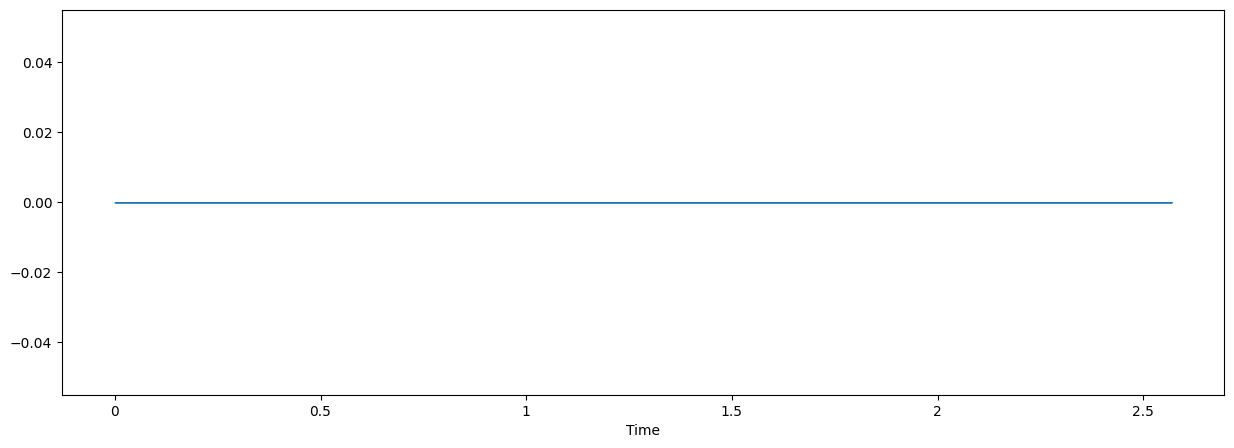

In [7]:
data, sampling_rate = librosa.load('./dataset/CREMA-D/1076_MTI_SAD_XX.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [8]:
df_joint_train.to_csv(f'./features/cache_all_features_train_V{VERSION}.csv',index=False)

# alternatively load cached features values
# df_joint_train_m = pd.read_csv('./features/cache_all_features_train.csv')
feature_column_names = [i for i in df_joint_train.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]
len(feature_column_names)

1546

## Test set processing

In [9]:
import time
start = time.time()
filename_list_test = master_data_test.renamed_file_path.tolist()
features_test =  pd.DataFrame(columns=['feature'])
bookmark = 0
bookmark=0
sample_rate_set = 16000
for index,filename in enumerate(filename_list_test):
    X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=sample_rate_set,offset=0.5)
    mfccs_60 = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=60)
    feature_mfccs_60_stats = get_stats_from_feature(mfccs_60)
    stft = np.abs(librosa.stft(X))
    feature_chroma_stft_stats = get_stats_from_feature(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    feature_mel_32_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=32, fmax=8000))
    feature_mel_64_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=64, fmax=8000))
    feature_mel_128_stats = get_stats_from_feature(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=128, fmax=8000))

    feature_zcr_stats = get_stats_from_feature(librosa.feature.zero_crossing_rate(y=X))
    feature_rms_stats = get_stats_from_feature(librosa.feature.rms(y=X))
    
    features  = np.concatenate((feature_mfccs_60_stats,
                                feature_chroma_stft_stats,
                                feature_mel_32_stats,
                                feature_mel_64_stats,
                                feature_mel_128_stats,
                                feature_zcr_stats,
                                feature_rms_stats
                              ), axis=0)
    features_test.loc[bookmark] = [features]
    bookmark=bookmark+1
end = time.time()
print(f"processing duration on feature extraction part 1 test set: {round(end-start)} seconds")

processing duration on feature extraction part 1 test set: 34 seconds


In [10]:
df_feat_test = pd.DataFrame(features_test['feature'].values.tolist())
df_feat_test.columns = column_names
df_joint_test = pd.concat([master_data_test.reset_index(drop=True),df_feat_test], axis=1)
df_joint_test.to_csv(f'./features/cache_features_part1_test_V{VERSION}.csv',index=False)

print("shape with part 1 features: ", df_joint_test.shape)
for feat_data_df in feat_data_list:
    feat_data_df = feat_data_df.drop(['Emotion'], axis=1).rename(columns={'Filepath':'file_path'})
    feat_data_df.file_path = feat_data_df.file_path.str.replace('_Angry.wav', '_angry.wav')
    df_joint_test = pd.merge(df_joint_test, feat_data_df, on='file_path', how='inner')
print("shape after merged features: ", df_joint_test.shape)
files_before_drop = df_joint_test.file_path.tolist()
df_joint_test = df_joint_test.dropna(how='any').drop(columns=['GNE_min_gne','split'])
removed_filepaths = list(set(files_before_drop) - set(df_joint_test.file_path.tolist()))

print("shape after drop Nan rows and constant feature: ", df_joint_test.shape)
print("removed filepaths if any: ", removed_filepaths) 

df_joint_test.to_csv(f'./features/cache_all_features_test_V{VERSION}.csv',index=False)

shape with part 1 features:  (1180, 1495)
shape after merged features:  (1180, 1552)
shape after drop Nan rows and constant feature:  (1180, 1550)
removed filepaths if any:  []


## Appendix Feature Extracted

| feature category   | num of sub attributes  |
| ------------------ | ---------------------- |
|MFCC stats*         |  60*5  |
|chroma stats        |  12*5  |
|Mel 32 stats        |  32*5  |
|Mel 64 stats        |  64*5  |
|Mel 64 stats        | 128*5  |
|**Part I Total above**|**1490**|
|Intensity           |    9  |
|pitch               |   12  |
|HNR                 |    6  |
|GNE                 |    5  |
|Local Jitter        |    1  |
|Local Shimmer       |    1  |
|Spectrum            |    9  | 
|formant             |   14  |
|**Part II Total above** | **57**|

*stats: 5 statistics on 2D matrix(MFCC,Chroma, Mel32, Mel 64 Mel 128) mean, median, standard deviation, 10%min, 90%max*